In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import scipy.optimize

In [2]:
import astro_time
import sgp4
import sensor

import tle_fitter

In [3]:
import public_astrostandards as PA
PA.init_all()
# PA.get_versions()

0

In [4]:
# grab some raw UDL obs; convert the time; sort
def prepObs( o_df ):
    '''
    given raw UDL obs, sort them and convert dates
    then run it through astro_time.convert_times to get a standard frame
    '''
    o_df['obTime_dt'] = pd.to_datetime( o_df['obTime'] )
    o_df = o_df.sort_values(by='obTime_dt')
    t_df = astro_time.convert_times( obs['obTime_dt'], PA )
    o_df = pd.concat( (t_df.reset_index(drop=True),o_df.reset_index(drop=True) ), axis=1 )
    return o_df 
    
obs    = pd.read_json('./19548.json.gz').sort_values(by='obTime').reset_index(drop=True)
obs_df = prepObs( obs )    

In [5]:
def rotateTEMEObs( O , harness ):
    '''
    given an ob (O) with ra / declination fields (J2K), convert to TEME

    assume that date has already been converted to ds50_utc with prepObs or astro_time.convert_time
    '''
    newRA  = (harness.ctypes.c_double)()
    newDec = (harness.ctypes.c_double)()
    PA.AstroFuncDll.RotRADec_EqnxToDate( 106,
                                        2,
                                        O['ds50_utc'],
                                        O['ra'],
                                        O['declination'],
                                        newRA,
                                        newDec )
    return ( np.float64(newRA),np.float64(newDec) )

# rotate a dataframe of obs into TEME and then also get a TEME look vector (for solving)
def rotateTEMEdf( df, harness ):
    ''''
    given a set of UDL obs in a dataframe that have been annotated with astro_time.convert_time,
    rotate all from J2K into TEME
    '''
    tv = df.apply( lambda X : rotateTEMEObs( X, harness ) , axis=1 )
    df['teme_ra']  = [ X[0] for X in tv ]
    df['teme_dec'] = [ X[1] for X in tv ]
    x = np.cos( np.radians(df['teme_dec']) ) * np.cos( np.radians( df['teme_ra'] ) )
    y = np.cos( np.radians(df['teme_dec']) ) * np.sin( np.radians( df['teme_ra'] ) )
    z = np.sin( np.radians(df['teme_dec'] ) )
    lv = np.hstack( ( x.values[:,np.newaxis], y.values[:,np.newaxis], z.values[:,np.newaxis] )  )
    df['teme_lv'] = lv.tolist()
    return df

obs_df = rotateTEMEdf( obs_df, PA )

In [6]:
L1 = '1 19548U 88091B   25281.05493527 -.00000297  00000+0  00000+0 0  9993'
L2 = '2 19548  12.7961 342.6596 0038175 340.8908  24.1736  1.00278194122860'

In [7]:
# -----------------------------------------------------------------------------------------------------
def optFunction( X, EH, return_scalar=True ):
    PA      = EH.PA
    XS_TLE  = PA.Cstr('',512)
    # take the function parameters (X) and overwrite the "new_tle" values based on FIELDS 
    for k,v in zip(EH.FIELDS,X) :  EH.new_tle[ k ] = v
    # --------------------- clear state
    PA.TleDll.TleRemoveAllSats()
    PA.Sgp4PropDll.Sgp4RemoveAllSats()
    # --------------------- init our test TLE from the modified data
    tleid = PA.TleDll.TleAddSatFrArray( EH.new_tle.data, XS_TLE )
    if tleid <= 0: return np.inf
    if PA.Sgp4PropDll.Sgp4InitSat( tleid ) != 0: return np.inf
    # --------------------- generate our test ephemeris
    test_frame = sgp4.propTLE_byID_df( tleid, EH.date_f, EH.PA )
    looks  =  sensor.compute_looks( EH.sensor_df, test_frame, EH.PA )
    RA_residuals  = EH.obs_df['teme_ra'] - looks['XA_TOPO_RA']
    DEC_residuals =  EH.obs_df['teme_dec'] - looks['XA_TOPO_DEC']

    rms = np.sum( RA_residuals.values ** 2 + DEC_residuals.values ** 2 ) / (2 * len(RA_residuals) )
    rv  = np.sqrt( rms )
    
    print('{:8.3f}                '.format(rv), end='\r')
    if return_scalar : return rv

    return looks

In [8]:
# -----------------------------------------------------------------------------------------------------
class eo_fitter( tle_fitter.tle_fitter ):
    def __init__( self, PA ):
        super().__init__( PA )
        self.line1 = None
        self.line2 = None

    def _set_new_epoch( self, epoch ):
        ''' assume that epoch is set, and that line1, line2 are also set '''
        self.PA.TleDll.TleRemoveAllSats()
        tleid = sgp4.addTLE( self.line1, self.line2, self.PA )
        assert sgp4.initTLE( tleid, self.PA )
        rv    = sgp4.propTLEToDS50s( tleid, [ epoch ], self.PA )[0]
        rv    = { 'teme_p' : rv[1:4], 'teme_v' : rv[4:7], 'ds50_utc' : self.epoch_ds50 }
        return rv

    def set_data( self, L1 : str, L2 : str, obs : list[ dict ] ):
        ''' 
        take an initial TLE as a guess (L1,L2) 
        take a list of JSON formatted obs (directly from UDL)
        solve for a new TLE
        '''
        self.line1      = L1
        self.line2      = L2
        self.obs        = obs

        self.obs_df     = prepObs( obs )
        self.obs_df     = rotateTEMEdf( self.obs_df, self.PA )
        self._look_vecs = np.vstack( self.obs_df['teme_lv'] )
        self.date_f     = self.obs_df[ ['ds50_utc','ds50_et','theta']].copy()

        # init the TLE from the lines data
        self.init_tle    = tle_fitter.TLE_str_to_XA_TLE( L1, L2, self.PA )
        self.new_tle     = tle_fitter.TLE_str_to_XA_TLE( L1, L2, self.PA )
        self.epoch_ds50  = self.obs_df.iloc[ -1 ]['ds50_utc']
        epoch_sv         = self._set_new_epoch( self.epoch_ds50 )
        self.set_from_sv( epoch_sv )
        self.new_tle['XA_TLE_EPOCH'] = epoch_sv['ds50_utc']
        # if this is a type-0, we need Kozai mean motion   
        if self.new_tle['XA_TLE_EPHTYPE'] == 0:
            self.new_tle['XA_TLE_MNMOTN'] = self.PA.AstroFuncDll.BrouwerToKozai( 
                                                self.new_tle['XA_TLE_ECCEN'], 
                                                self.new_tle['XA_TLE_INCLI'],
                                                self.new_tle['XA_TLE_MNMOTN'] )

        self.sensor_df        = self.obs_df[['ds50_utc','senlat','senlon','senalt','theta']]
        self.sensor_df        = self.sensor_df.rename( columns = {'senlat' : 'lat','senlon' : 'lon', 'senalt' : 'height' } )
        self.sensor_df        = sensor.llh_to_eci( self.sensor_df, self.PA )
        return self

                                       
    def fit_tle( self ):
        # -----------------------------  nelder mead -----------------------------
        # if your seed is not near the final, nelder works great (at the expense of time)
        ans   = scipy.optimize.minimize(optFunction, 
                                        self.get_init_fields(),
                                        args    = (self,True),
                                        method  = 'Nelder-Mead' ,
                                        options = {'xatol' : 0.001, 'fatol' : 0.01, 'initial_simplex' : self.initial_simplex() } )

        self.ans = ans
        if ans.success:
            A.reset_tle()
            # now update with perturbed values (not sure if this is necessary... last step should be there)
            for k,v in zip(A.FIELDS,ans.x) : A.new_tle[k] = v
            return True
        return False


obs    = pd.read_json('./19548.json.gz').sort_values(by='obTime').reset_index(drop=True)    
# !!!!!!!!!!! REMEMBER to set type before setting data
A = eo_fitter( PA ).set_type4().set_data( L1, L2, obs ).clear_nonconservatives()
converged = A.fit_tle()

# Plot an answer

1 19548U 88091B   25281.05493527 -.00000297  00000+0  00000+0 0  9993
2 19548  12.7961 342.6596 0038175 340.8908  24.1736  1.00278194122860
1 19548           25279.99845760 +.00000000  00000 0  00000 0 0 0999
2 19548  11.4709 342.8060 0059495 333.1481  10.0626  1.0027724412286


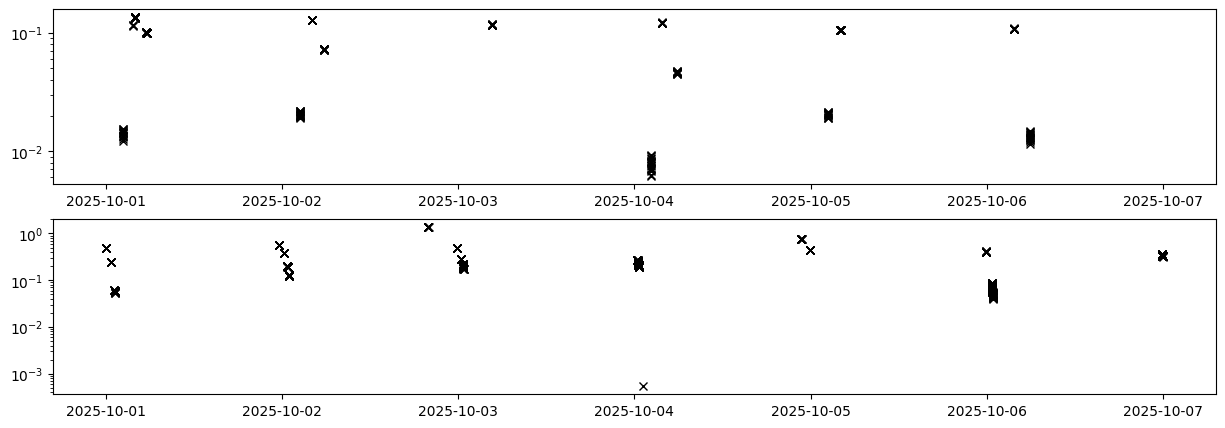

In [9]:
import matplotlib.pyplot as plt

if converged:
    print(L1)
    print(L2)
    nL1,nL2 = A.getLines()
    print( '\n'.join( [nL1, nL2] ) )

    # calculate the residuals
    test_eph      = sgp4.propTLE_df( A.date_f, nL1, nL2, A.PA )
    test_looks    = sensor.compute_looks( A.sensor_df, test_eph, A.PA )
    ra_residuals  = test_looks['XA_TOPO_RA'] - A.obs_df['teme_ra']
    dec_residuals = test_looks['XA_TOPO_DEC'] - A.obs_df['teme_dec']
    plt.close('all')
    f,ax = plt.subplots(2,1,figsize=(15,5))
    ax[0].semilogy( A.obs_df['obTime_dt'], ra_residuals,'kx')
    ax[1].semilogy( A.obs_df['obTime_dt'], dec_residuals,'kx')

In [10]:
# Another test

In [11]:
tl1 = '1 90036U 25206B   25274.90623402 +.00000000  30000-1  10000-1 4 9999'
tl2 = '2 90036  71.8879 325.2798 0161957   3.2262   6.0327  2.0816028900000'

obs    = pd.read_csv('found.csv').sort_values(by='obTime').reset_index(drop=True)    
# !!!!!!!!!!! REMEMBER to set type before setting data
B = eo_fitter( PA ).set_type0().set_data( tl1, tl2, obs ).set_satno(99999).clear_nonconservatives()
converged = B.fit_tle()

In [12]:
B.getLines()

('1 99999           25280.13966221 +.00000000  00000 0  00000 0 0 9999',
 '2 99999  69.5121 323.0525 0000006   1.4330 352.1379  2.0815511300000')

1 90036U 25206B   25274.90623402 +.00000000  30000-1  10000-1 4 9999
2 90036  71.8879 325.2798 0161957   3.2262   6.0327  2.0816028900000
1 99999           25280.13966221 +.00000000  00000 0  00000 0 0 9999
2 99999  69.5121 323.0525 0000006   1.4330 352.1379  2.0815511300000


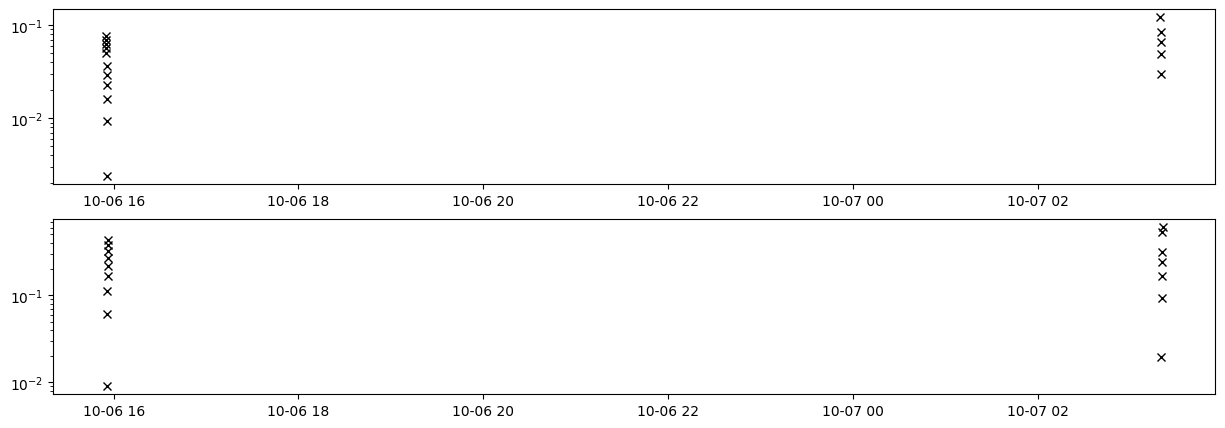

In [13]:
if converged:
    print(tl1)
    print(tl2)
    nL1,nL2 = B.getLines()
    print( '\n'.join( [nL1, nL2] ) )

    # calculate the residuals
    test_eph      = sgp4.propTLE_df( B.date_f, nL1, nL2, A.PA )
    test_looks    = sensor.compute_looks( B.sensor_df, test_eph, B.PA )
    ra_residuals  = test_looks['XA_TOPO_RA'] - B.obs_df['teme_ra']
    dec_residuals = test_looks['XA_TOPO_DEC'] - B.obs_df['teme_dec']
    plt.close('all')
    f,ax = plt.subplots(2,1,figsize=(15,5))
    ax[0].semilogy( B.obs_df['obTime_dt'], ra_residuals,'kx')
    ax[1].semilogy( B.obs_df['obTime_dt'], dec_residuals,'kx')

In [17]:
dec_residuals * 3600

0    -1662.986459
1    -1473.523072
2    -1283.648167
3    -1097.243888
4     -907.884183
5     -530.518832
6     -344.177214
7     -154.805645
8       32.501652
9      220.498482
10     408.863066
11     596.333809
12     785.296171
13     973.019640
14    1162.126821
15    1349.657953
16    1537.557563
17   -2033.371796
18   -1507.559620
19   -1244.921679
20    -981.360561
21    -717.131333
22    -192.606457
23      70.419516
24     336.349727
25     598.021786
26     860.099905
27    1123.960274
28    1913.557604
29    2176.822671
dtype: float64